# Exploratory Data Analysis

## import packages

In [1]:
import sys
sys.path.append("/Users/lesleymi/data_science_portfolio/IMDB_Sentiment_Analysis/src")
# custom functions
import imdb_functions as imdb

# data wrangling
import pandas as pd
import numpy as np

# nlp
from nltk.probability import FreqDist

# viz
import plotly.express as px
import matplotlib.pyplot as plt

# Plotly Dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import base64

In [2]:
from keplergl import KeplerGl
from wordcloud import WordCloud

## functions 

In [3]:
def make_top_n(df, n, polarity):
    
    plot = px.bar(df,
                  x='word_count',
                  y='words',
                  labels={'words':'Top ' + str(n) + ' Words', 'word_count':'Word Count'},
                  title='Top ' + str(n) +' Most Frequent Words in ' + polarity + ' Reviews')
    return plot

## load train set

In [4]:
train = pd.read_parquet("data/Train.parquet")
# replace 0/1s with human readable labels
train = train.replace({'label':{0:'negative',
                                1: 'positive'}})
# replace 0/1s with human readable labels
train_clean = pd.read_parquet("data/train_clean.parquet")
train_clean = train_clean.replace({'label':{0:'negative',
                                1: 'positive'}})

In [5]:
# look at raw train
train.head(3)

,text,label,tokenized_docs
0,I grew up (b. 1965) watching and loving the Th...,negative,"[I, grew, up, (, b., 1965, ), watching, and, l..."
1,"When I put this movie in my DVD player, and sa...",negative,"[When, I, put, this, movie, in, my, DVD, playe..."
2,Why do people who do not know what a particula...,negative,"[Why, do, people, who, do, not, know, what, a,..."


In [6]:
# look at clean train
train_clean.head(3)

,text,label,tokenized_docs
0,grow watch love thunderbirds mate school watch...,negative,"[grow, watch, love, thunderbirds, mate, school..."
1,movie dvd player sit coke chip expectation hop...,negative,"[movie, dvd, player, sit, coke, chip, expectat..."
2,people know particular time past like feel nee...,negative,"[people, know, particular, time, past, like, f..."


In [7]:
print("Number of observations: {}".format(train.shape[0]))
print("Number of unique labels: {}".format(train.label.nunique()))
print("The unique labels are: {0} and {1}".format(train.label.unique()[0],
                                                 train.label.unique()[1]))

Number of observations: 40000
Number of unique labels: 2
The unique labels are: negative and positive


## look at example of a neg review

In [8]:
# get a negative review 
neg_rev = train.query('label == "negative"').text.values

## look at example of a pos review

In [9]:
# get a positive review 
pos_rev = train.query('label == "positive"').text.values


**There are `html` tags present in the data here; this will have to be removed during data cleaning.**

## Visualize count of pos/neg

The visualization of positive vs negative review counts indicates a balanced dataset with
the count of positive reviews nearly equal to the count of negative reviews.

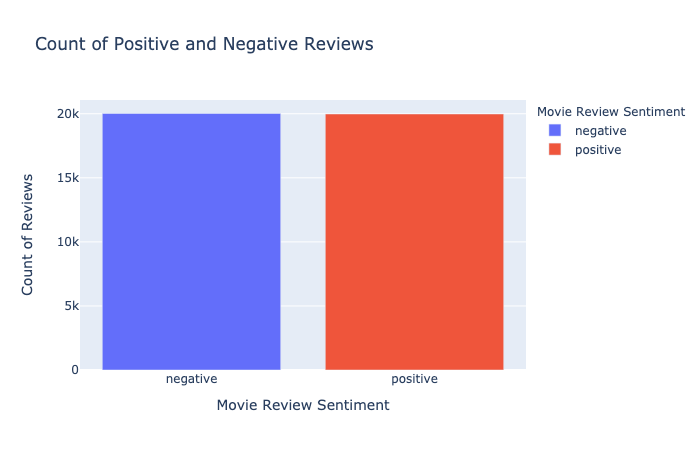

In [10]:
# how many positive/negative reviews are there? 
df = (train.groupby(by='label')
          .count()
          .reset_index()
          .rename(columns={'text':'count'}))

# plot he count of pos/neg labels
plot1 = px.bar(df,
       x='label',
       y='count',
       color='label',
       title='Count of Positive and Negative Reviews',
       labels={'label': 'Movie Review Sentiment',
               'count': 'Count of Reviews'})
plot1.show('png')

In [11]:
# get number of tokens in each document
clean_doc_length = train_clean.tokenized_docs.apply(func=len).to_frame(name='num_tokens')
clean_doc_length.head()

,num_tokens
0,75
1,132
2,84
3,27
4,86


In [12]:
# add document length to text df
train_clean['num_tokens'] = clean_doc_length
train_clean.head(3)

,text,label,tokenized_docs,num_tokens
0,grow watch love thunderbirds mate school watch...,negative,"[grow, watch, love, thunderbirds, mate, school...",75
1,movie dvd player sit coke chip expectation hop...,negative,"[movie, dvd, player, sit, coke, chip, expectat...",132
2,people know particular time past like feel nee...,negative,"[people, know, particular, time, past, like, f...",84


In [13]:
# how many words in the corpus in total?
print("There are {0} total tokens in the cleaned corpus.".format(train_clean.num_tokens.sum()))

There are 4010988 total tokens in the cleaned corpus.


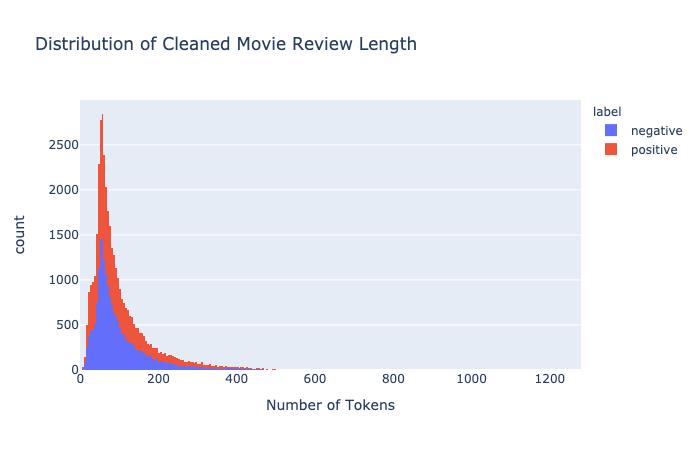

In [14]:
# visualize document length by sentiment label
plot4 = px.histogram(train_clean,
                     x='num_tokens',
                     color='label',
                     labels={'num_tokens':'Number of Tokens'},
                     title='Distribution of Cleaned Movie Review Length')
plot4.show('png')



## Get All words as BOW

In [15]:
# combine the documents into a single bag of words
clean_docs_bow = np.concatenate(train_clean.tokenized_docs)

## Get Pos/Neg words as BOW

In [16]:
# filter for pos/neg reviews
train_clean_pos = train_clean.query('label == "positive"').tokenized_docs.to_list()
train_clean_neg = train_clean.query('label == "negative"').tokenized_docs.to_list()

# combine the documents into a single bag of words
positive_bow = np.concatenate(train_clean_pos)
negative_bow = np.concatenate(train_clean_neg)

## Wordcloud

In [17]:
word_cloud = WordCloud(max_words=100, 
                       width=800, 
                       height=500, 
                       background_color='white').generate(" ".join(clean_docs_bow))

(-0.5, 799.5, 499.5, -0.5)

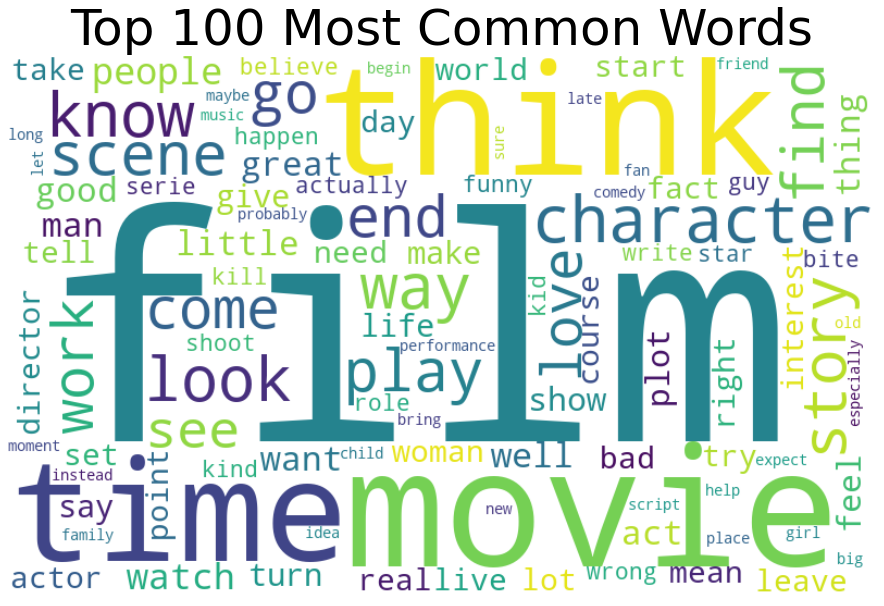

In [18]:
wordcloud_fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Top 100 Most Common Words', fontsize=50)
plt.axis("off")

In [19]:
wordcloud_fig.savefig('wordcloud_fig.png')

## Build Dashboard

In [20]:
## intro text 

markdown_text1 = """
This app displays visualizations of the IMDB movie review dataset found [here on Kaggle](https://www.kaggle.com/columbine/imdb-dataset-sentiment-analysis-in-csv-format).
All the code for this analysis can be found on GitHub [here](https://github.com/aromatic-toast/IMDB_Sentiment_Analysis). The data displayed here is for 40,000 movie reviews
labeled as either positive or negative reviews. 
"""

markdown_text2 = """
Use the tabs to navigate to an example of a positive or negative movie review. 
Click the arrows inside the box up and down to browse through different reviews or enter a number
directly between 0 and 19,000. 
"""

In [25]:
# add positive and negative review examples to a table
table_header = [html.Thead(
    html.Tr([html.Th("Positive Review"), html.Th('Negative Review')])
)]
row1 = html.Tr([html.Td(pos_rev), html.Td(neg_rev)])
table_body = [html.Tbody([row1])]
table = dbc.Table(table_header + table_body,
                  bordered=True,
                  striped=True)

# get the vocabulary and their frequencies
all_words = (pd.DataFrame(clean_docs_bow, columns=['word_count'])
             .word_count
             .value_counts()
             .reset_index()
             .rename(columns={'index':'words'}))

pos_words = (pd.DataFrame(positive_bow, columns=['word_count'])
             .word_count
             .value_counts()
             .reset_index()
             .rename(columns={'index':'words'}))

neg_words = (pd.DataFrame(negative_bow, columns=['word_count'])
             .word_count
             .value_counts()
             .reset_index()
             .rename(columns={'index':'words'}))

encoded_image = base64.b64encode(open('wordcloud_fig.png', 'rb').read())

PLOTLY_LOGO = "https://images.plot.ly/logo/new-branding/plotly-logomark.png"
navbar = dbc.Navbar(
    [
        html.A(
            # Use row and col to control vertical alignment of logo / brand
            dbc.Row(
                [
                    dbc.Col(html.Img(src=PLOTLY_LOGO, height="40px")),
                    dbc.Col(dbc.NavbarBrand("IMDB Movie Reviews", className="ml-2")),
                ],
                align="center",
                no_gutters=True,
            ),
            href="https://plot.ly",
        )
    ],
    color="dark",
    dark=True,
    id='nav-bar'
)

intro_tooltip = dbc.Tooltip(
    #dcc.Markdown(markdown_text1),
    markdown_text1,
    target='nav-bar',
    placement='bottom'
)

tab1_tooltip = dbc.Tooltip(
    markdown_text2,
    target='tab1',
    placement='bottom'
)

#external_stylesheets = [dbc.themes.CERULEAN]
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.CYBORG])

# Create server variable with Flask server object for use with gunicorn
server = app.server

app.layout = html.Div(children=[navbar,
                                #html.H3(children='Exploratory Text Analysis'),
                                tooltip,
                                
                                # App intro Text 
                                dbc.Col(dcc.Markdown(markdown_text1), width=4),
                                
                                # 3 main tabs
                                dcc.Tabs([
                                    # tab to text documents
                                    dcc.Tab(id='tab1', label='Read Movie Reviews', children=[
                                        dbc.Row(html.Br()),
                                        dbc.Row(dbc.Col([html.H6(markdown_text2)], width=4)),
                                        dbc.Row(html.Br()),
                                        dbc.Row(dbc.Col([
                                            html.Label("Enter an integer below:")
                                        ])),
                                        dbc.Row(dbc.Col([
                                            dcc.Input(id='sample-review', 
                                                      value=0,
                                                      placeholder='Input Review Number', 
                                                      type='number')], width=4)),
                                        dbc.Row(html.Br()),
                                        dbc.Row(dbc.Col([
                                            dbc.Tabs([
                                            dbc.Tab(id='tab1_content', label='Positive'),
                                            dbc.Tab(id='tab2_content', label='Negative')
                                        ])
                                        ])) 
                                    ]),
                                                
                                    # tab to hold the summary plots 
                                    dcc.Tab(label='Plots', children=[
                                        dbc.Container([
                                            dbc.Row(html.Br()),
                                            dbc.Row([dbc.Col(dcc.Graph(id='plot1', figure=plot1)),
                                                     dbc.Col(dcc.Graph(id='plot4', figure=plot4))]),
                                            dbc.Row(html.Br()),
                                            dbc.Row([
                                                dbc.Col([
                                                    html.H4('Filter Top Words')
                                                ], width=3)
                                            ]),
                                            dbc.Row([
                                                dbc.Col(
                                                    dcc.Dropdown(
                                                        id='drop-down',
                                                        options=[
                                                            {'label':'5', 'value':5},
                                                            {'label':'10', 'value':10},
                                                            {'label': '15', 'value':15}
                                                        ], 
                                                        placeholder='Select N', value=10),
                                                    width=1)
                                            ]),
                                            dbc.Row([dbc.Col(dcc.Graph(id='top-overall-words')),
                                                     dbc.Col(dcc.Graph(id='top-pos-words')),
                                                     dbc.Col(dcc.Graph(id='top-neg-words'))]),],
                                            fluid=True)
                                    ]),
                                    
                                    # tab to contain a map
                                    dcc.Tab(label='Wordcloud', children=[
                                        dbc.Row(html.Br()),
                                        dbc.Row(dbc.Col(html.H5("Some instructions on how to use the map. "))),
                                        dbc.Row(html.Br()),
                                        dbc.Row(dbc.Col([
                                            html.Img(id='wordcloud', src='data:image/png;base64,{}'.format(encoded_image.decode()))
                                        ]))
                                        
                                        
                                    ])
                                ])
                               ])

@app.callback(
    Output('top-overall-words', component_property='figure'),
    Input('drop-down', component_property='value')
)
def get_top_overall_words(n):
    # filter vocabulary to top n words
    filtered_df = all_words.head(n)
    # make the plot
    plot = make_top_n(filtered_df, n, 'All')
    return plot

@app.callback(
    Output('top-pos-words', component_property='figure'),
    Input('drop-down', component_property='value'))
def get_top_pos_words(n):
    # filter vocabulary to top n words
    filtered_df = pos_words.head(n)
    # make the plot
    plot = make_top_n(filtered_df, n, 'Positive')
    return plot

@app.callback(
    Output('top-neg-words', component_property='figure'),
    Input('drop-down', component_property='value'))
def get_top_neg_words(n):
    # filter vocabulary to top n words
    filtered_df = neg_words.head(n)
    # make the plot
    plot = make_top_n(filtered_df, n, 'Negative')
    return plot

    
@app.callback(
    Output('tab1_content', component_property='children'),
    Input('sample-review', component_property='value'))
def get_pos_review(index):
    tab1_content = dbc.Card(
        dbc.CardBody(
            # filter a document from the positive reviews
            pos_rev[index]
        ))
    return tab1_content

@app.callback(
    Output('tab2_content', component_property='children'),
    Input('sample-review', component_property='value'))

def get_neg_review(index):
        tab2_content = dbc.Card(
            dbc.CardBody(
                # filter a document from the negative reviews
                neg_rev[index]
        ))
        return tab2_content



In [26]:
app.run_server(port=8055)

Dash app running on http://127.0.0.1:8055/


In [23]:
tooltip = html.Div(
    [
        html.P(
            [
                "I wonder what ",
                html.Span(
                    "floccinaucinihilipilification",
                    id="tooltip-target",
                    style={"textDecoration": "underline", "cursor": "pointer"},
                ),
                " means?",
            ]
        ),
        dbc.Tooltip(
            "Noun: rare, "
            "the action or habit of estimating something as worthless.",
            target="tooltip-target",
        ),
    ]
)

In [24]:
tooltip

Div([P(['I wonder what ', Span(children='floccinaucinihilipilification', id='tooltip-target', style={'textDecoration': 'underline', 'cursor': 'pointer'}), ' means?']), Tooltip(children='Noun: rare, the action or habit of estimating something as worthless.', target='tooltip-target')])